# Scalable Logistic Regression

In this Notebook we will explore the performance of Logistic Regression on the datasets we already used in the Notebook for Decision Trees for Classification, Lab Notebook 6. 

We start with the [Spambase Dataset](http://archive.ics.uci.edu/ml/datasets/Spambase).

We create a <tt>SparkSession</tt> (unless you are running in a pyspark shell)

In [1]:
# import findspark
# findspark.init()
from pyspark.sql import SparkSession
import numpy as np
spark = SparkSession.builder.master("local[2]").appName("COM6012 Logistic Regression").getOrCreate()

We load the dataset and the names of the features and label. We cache the dataframe for efficiently performing several operations to rawdata inside a loop.

In [2]:
rawdata = spark.read.csv('../Data/spambase.data')
rawdata.cache()
ncolumns = len(rawdata.columns)
spam_names = [spam_names.rstrip('\n') for spam_names in open('../Data/spambase.data.names')]
number_names = np.shape(spam_names)[0]
for i in range(number_names):
    local = spam_names[i]
    colon_pos = local.find(':')
    spam_names[i] = local[:colon_pos]

We now rename the columns using the more familiar names for the features.

In [3]:
schemaNames = rawdata.schema.names
spam_names[ncolumns-1] = 'labels'
for i in range(ncolumns):
    rawdata = rawdata.withColumnRenamed(schemaNames[i], spam_names[i])

We import the Double type from pyspark.sql.types, use the withColumn method for the dataframe and cast() the column to DoubleType.

In [4]:
from pyspark.sql.types import DoubleType
for i in range(ncolumns):
    rawdata = rawdata.withColumn(spam_names[i], rawdata[spam_names[i]].cast(DoubleType()))

We use the VectorAssembler to concatenate all the features in a vector.

In [5]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols = spam_names[0:ncolumns-1], outputCol = 'features') 
raw_plus_vector = assembler.transform(rawdata)
data = raw_plus_vector.select('features','labels')

We use the same seed that we used in the previous Notebook to split the data into training and test.

In [6]:
(trainingData, testData) = data.randomSplit([0.7, 0.3], 42)

We are now in a position to train the logistic regression model. But before, let us look at a list of relevant parameters. A comprehensive list of parameters for [LogisticRegression](http://spark.apache.org/docs/2.3.2/api/python/pyspark.ml.html?highlight=logisticregression#pyspark.ml.classification.LogisticRegression) can be found in the Python API for PySpark.

> **maxIter**: max number of iterations. <p>
    **regParam**: regularization parameter ($\ge 0$).<p>
        **elasticNetParam**: mixing parameter for ElasticNet. It takes values in the range [0,1]. For $\alpha=0$, the penalty is an $\ell_2$. For $\alpha=1$, the penalty is an $\ell_1$.<p>
        **family**: binomial (binary classification) or multinomial (multi-class classification). It can also be 'auto'.<p>
            **standardization**: whether to standardize the training features before fitting the model. It can be true or false (True by default).
            
The function to optimise has the form
$$
f(\mathbf{w}) = LL(\mathbf{w}) + \lambda\Big[\alpha\|\mathbf{w}\|_1 + (1-\alpha)\frac{1}{2}\|\mathbf{w}\|_2\Big],
$$
where $LL(\mathbf{w})$ is the logistic loss given as
$$
LL(\mathbf{w}) = \sum_{n=1}^N \log[1+\exp(-y_n\mathbf{w}^{\top}\mathbf{x}_n)].
$$

Let us train different classifiers on the same training data. We start with logistic regression, without regularization, so $\lambda=0$.


In [9]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features', labelCol='labels', maxIter=50, regParam=0, family="binomial")
lrModel1 = lr.fit(trainingData)
predictions = lrModel1.transform(testData)

Let us compute the accuracy.

In [11]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator\
      (labelCol="labels", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g " % accuracy)

Accuracy = 0.685116 


We now save the vector $\mathbf{w}$ obtained without regularisation

In [11]:
w_no_reg = lrModel1.coefficients.values

We now train a second logistic regression classifier using only $\ell_1$ regularisation ($\lambda=0.01$ and $\alpha=1$)

In [7]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

lrL1 = LogisticRegression(featuresCol='features', labelCol='labels', maxIter=50, regParam = 0.8#regParam=0.01
                          , elasticNetParam = 0.1#elasticNetParam=1
                          , family="binomial")
lrModelL1 = lrL1.fit(trainingData)
predictions = lrModelL1.transform(testData)
# With Predictions
evaluator = MulticlassClassificationEvaluator\
      (labelCol="labels", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g " % accuracy)

Accuracy = 0.685116 


We now save the vector $\mathbf{w}$ obtained for the L1 regularisation

In [9]:
w_L1 = lrModelL1.coefficients.values # get 系数w 值

Let us plt the values of the coefficients $\mathbf{w}$ for the no regularisation case and the L1 regularisation case.

Text(0.5, 1.0, 'L1 regularisation')

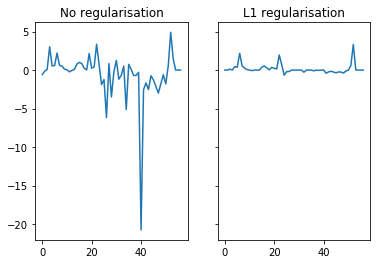

In [14]:
%matplotlib inline 
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(w_no_reg)
ax1.set_title('No regularisation')
ax2.plot(w_L1)
ax2.set_title('L1 regularisation')

Let us find out which features are preferred by each method. Without regularisation, the most relevant feature is

In [15]:
spam_names[np.argmax(np.abs(w_no_reg))] # 得到未正则化最有用的特征

'word_freq_cs'

With L1 regularisation, the most relevant feature is

In [10]:
spam_names[np.argmax(np.abs(w_L1))] # 得到正贼话最有用的特征

'word_freq_you'

This last result is consistent with the most relevant feature given by the Decision Tree Classifier of Lab Notebook 6.

### Question 1

Try a pure L2 regularisation and an elastic net regularisation on the same data partitions from above. Compare accuracies and find the most relevant features for both cases. Are these features the same than the one obtained for L1 regularisation?

### Question 2

Instead of creating a logistic regression model trying one type of regularisation at a time, create a [ParamGridBuilder](http://spark.apache.org/docs/2.3.2/api/python/pyspark.ml.html?highlight=paramgridbuilder#pyspark.ml.tuning.ParamGridBuilder) to be used inside a [CrossValidator](http://spark.apache.org/docs/2.3.2/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) to fine tune the best type of regularisation and the best parameters for that type of regularisation. Use five folds for the CrossValidator.

A useful method for the logistic regression model is the [summary](http://spark.apache.org/docs/2.3.2/api/python/pyspark.ml.html?highlight=logisticregressionsummary#pyspark.ml.classification.LogisticRegressionSummary) method. 

In [16]:
lrModel1.summary.accuracy

0.9338235294117647

The accuracy here is different to the one we got before. Why?

Other quantities that can be obtained from the summary include falsePositiveRateByLabel, precisionByLabel, recallByLabel, among others. For an exhaustive list, please read [here](http://spark.apache.org/docs/2.3.2/api/python/pyspark.ml.html?highlight=logisticregressionsummary#pyspark.ml.classification.LogisticRegressionSummary).

In [17]:
print("Precision by label:")
for i, prec in enumerate(lrModel1.summary.precisionByLabel):
    print("label %d: %s" % (i, prec))

Precision by label:
label 0: 0.9350520575111552
label 1: 0.9318364073777065


### Question 3

Create a logistic regression classifier that runs on the [default of credit cards](http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) dataset. Several of the features in this dataset are categorical. Use the tools provided by PySpark (pyspark.ml.feature) for treating categorical variables. 

Note also that this dataset has a different format to the Spambase dataset above - you will need to convert from XLS format to, say, CSV, before using the data. You can use any available tool for this: for example, Excell has an export option, or there is a command line tool <tt>xls2csv</tt> available on Linux.